## ref : https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

In [1]:
import numpy as np
import pandas as pd

import datetime
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [16, 10]

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


def show_table(df, sample_num=4):
    tail_num = sample_num//2
    head_num = sample_num-tail_num
    
    print('>>> shape :', df.shape)
    print('>>> number of NA :', df.isna().sum().sum())
    display(pd.concat([df.head(head_num), df.tail(tail_num)]))

/kaggle/input/new-york-city-taxi-with-osrm/second_fastest_routes_test.csv
/kaggle/input/new-york-city-taxi-with-osrm/accidents_2016.csv
/kaggle/input/new-york-city-taxi-with-osrm/train.csv
/kaggle/input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv
/kaggle/input/new-york-city-taxi-with-osrm/fastest_routes_test.csv
/kaggle/input/new-york-city-taxi-with-osrm/test.csv
/kaggle/input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv
/kaggle/input/new-york-city-taxi-with-osrm/second_fastest_routes_train.csv
/kaggle/input/nyc-taxi-trip-duration/test.zip
/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip
/kaggle/input/nyc-taxi-trip-duration/train.zip


## Data Understanding

In [2]:
train = pd.read_csv('../input/nyc-taxi-trip-duration/train.zip')
test = pd.read_csv('../input/nyc-taxi-trip-duration/test.zip')
sample_submission = pd.read_csv('../input/nyc-taxi-trip-duration/sample_submission.zip')

print('< Train dataset >')
show_table(train, sample_num=4)

print('\n\n< Test dataset >')
show_table(test)

< Train dataset >
>>> shape : (1458644, 11)
>>> number of NA : 0


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198




< Test dataset >
>>> shape : (625134, 9)
>>> number of NA : 0


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
625132,id1384355,1,2016-01-01 00:00:28,1,-73.976501,40.733562,-73.854263,40.891788,N
625133,id0621643,2,2016-01-01 00:00:22,2,-73.981850,40.716881,-73.969330,40.769379,N


- Columns 'dropoff_datetime' and 'trip_duration' are only available in train dataset.

In [3]:
print('id is unique') if train['id'].nunique() == train.shape[0] else print('There is redundant id')
print('Train and Test datasets are distinct') if np.intersect1d( train['id'], test['id'] ).shape[0]==0 else print('There is redundant id between train and test datasets')
print('Number of NA in train dataset :', train.isna().sum().sum())
print('Number of NA in test dataset :', test.isna().sum().sum())
print()
print('Unique values in store_and_fwd_flag :', pd.concat([train['store_and_fwd_flag'], test['store_and_fwd_flag']]).unique())
print('Min trip_duration (sec) :', train['trip_duration'].min())
print('Max trip_duration (sec) :', train['trip_duration'].max())
print(f'Max trip_duration (hour) : {train["trip_duration"].max()/3600:.2f}')

id is unique
Train and Test datasets are distinct
Number of NA in train dataset : 0
Number of NA in test dataset : 0

Unique values in store_and_fwd_flag : ['N' 'Y']
Min trip_duration (sec) : 1
Max trip_duration (sec) : 3526282
Max trip_duration (hour) : 979.52


In [4]:
train.dtypes.to_frame().T

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,object,int64,object,object,int64,float64,float64,float64,float64,object,int64


## Converting data types & Check the target feature

In [5]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

train['check_trip_duration'] = train['dropoff_datetime'].subtract(train['pickup_datetime']).map(lambda x : x.total_seconds())
check_duration_diff = np.abs(train['check_trip_duration'].values - train['trip_duration'].values) > 1
print('>>> Warning! Check the difference between duration and datetime') if np.any(check_duration_diff) else print('>>> duration and datetime are ok')

print('>>> Max trip_duration :', train['trip_duration'].max()//3600)

>>> duration and datetime are ok
>>> Max trip_duration : 979


We can see that max trip duration is around 1000 hours. Fortunately, the evaluation metric is RMSLE, not RMSE. Outliers will cause less trouble. We could logtransform the target feature and use RMSE during training.

## Check the distribution of target feature (trip_duration, log_trip_duration)

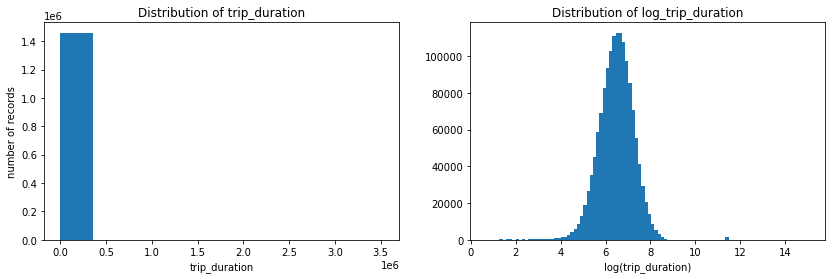

In [6]:
train['log_trip_duration'] = np.log1p(train['trip_duration'])


fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].hist(train['trip_duration'])
ax[0].set_title('Distribution of trip_duration')
ax[0].set_xlabel('trip_duration')
ax[0].set_ylabel('number of records')

ax[1].hist(train['log_trip_duration'], bins=100)
ax[1].set_title('Distribution of log_trip_duration')
ax[1].set_xlabel('log(trip_duration)')

plt.show()